# Predictions on Credit Data Set


For this task, we will load the data set we used in the EDA session. Recall that this data set was provided by www.creditriskanalytics.com. As a quick reminder: 

## About the data set

The data set consists of 5960 observations and 13 variables. 
The variables are defined as the following:

- BAD: 1=default; 0=non-default
- LOAN: amount of the loan request
- MORTDUE: amount due on existing mortgage
- VALUE: value of current property
- REASON: DebtCon=debt consolidation; HomeImp=home improvement
- JOB: occupational categories
- YOJ: years at present job
- DEROG: number of major derogatory reports
- DELINQ: number of delinquent credit lines
- CLAGE: age of oldest credit line in months
- NINQ: number of recent credit inquiries
- CLNO: number of credit lines
- DEBTINC: debt-to-income ratio

<br> <br> <br>
This notebook will elaborate on the process of different machine learning techniques and their evaluation, including logistic regression, random forest and gradient boosting.

Before applying any algorithm, we will import the necessary packages and load the data. After, we will quickly display some general information about the data set to help us recall. If you are not familiar with this data set, please look at the explanatory data analysis notebook to ensure you understand the data before interpreting the results later. There you can also see the original values of all numeric variables before standardization.

An important finding is the imbalance of the data set, which contains only about 20% of 'BAD' observations. 


In [300]:
#Import packages
import importlib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as stat
import xgboost as xgb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV


In [301]:
# Load data
credit = pd.read_csv('/Users/wiebkeberlin/Desktop/creditnew.csv')
credit.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5.960000e+03,5.960000e+03,5.960000e+03,5.960000e+03,5.960000e+03,5.960000e+03,5.960000e+03,5.960000e+03,5.960000e+03,5.960000e+03
mean,0.199497,-9.123202e-16,6.588596e-16,-8.776630e-16,1.417397e-16,3.113794e-16,-9.155987e-16,-1.203363e-16,-1.761455e-16,1.181139e-15,1.265040e-15
std,0.399656,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00
min,0.000000,-1.562299e+00,-1.424276e+00,-1.707224e+00,-1.168611e+00,-1.239592e+00,-1.133918e+00,-1.850350e+00,-1.134248e+00,-1.986375e+00,-1.696035e+00
25%,0.000000,-6.699632e-01,-5.995930e-01,-5.960053e-01,-7.818625e-01,-1.183341e-01,-2.672662e-01,-6.773687e-01,-5.668382e-01,-5.983115e-01,-3.744374e-01
50%,0.000000,-2.059485e-01,-1.186451e-01,-1.975027e-01,-2.661978e-01,-1.183341e-01,-2.672662e-01,-4.046820e-02,-5.668382e-01,-4.308588e-02,3.429367e-01
75%,0.000000,4.186868e-01,4.409223e-01,3.272283e-01,5.072992e-01,-1.183341e-01,-2.672662e-01,6.122157e-01,5.679806e-01,5.121397e-01,7.161369e-01
max,1.000000,6.361645e+00,7.025058e+00,1.292491e+01,4.245868e+00,1.109425e+01,1.273251e+01,1.077030e+01,9.079122e+00,4.676332e+00,1.095704e+01


# Problem to solve 


This data set stages a common problem for banks and lenders. It is important, that banks can ensure which people are likely to pay back a loan and which are likely to default, as obviously wrong decisions could lead to high losses. This data set contains information about the customers as well as the outcome variable 'BAD'. This allows us to find generalizable patterns in these two groups ('GOOD' and 'BAD') through supervised machine learning.


# Let's get started


Before we apply any algorithms to our data, we need to ensure that it is in the right format. Not every algorithm can handle categorical variables. The way to overcome this obstacle is by using dummy variables.



In [302]:
credit.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   REASON   5960 non-null   object 
 2   JOB      5960 non-null   object 
 3   LOAN     5960 non-null   float64
 4   MORTDUE  5960 non-null   float64
 5   VALUE    5960 non-null   float64
 6   YOJ      5960 non-null   float64
 7   DEROG    5960 non-null   float64
 8   DELINQ   5960 non-null   float64
 9   CLAGE    5960 non-null   float64
 10  NINQ     5960 non-null   float64
 11  CLNO     5960 non-null   float64
 12  DEBTINC  5960 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 605.4+ KB


### Dummy Variables: What are they and why do we use them?

A dummy variables is a binary vectors of a specific category of a variable. For example, a vector for the variable 'JOB' and category 'Office'. In this vector the value would  a 1 for every observation with an office job, and 0 for all others. 

We require dummy encoding as categorical data is common and carries valuable information, however, are not able to be interpreted by all algorithms.

This can be clarified through the example of a logistic regression. Regression analysis is common practice for using a continuous variable (e.g. 'LOAN') to predict the independent variable ('BAD' in this example). As you cannot rank and/or calculate a meaningful distance between categories, this interpretation is not possible. However, if we split up these variable into the earlier described dummy variables, we create a numeric variable by only using the number 0 and 1. The new variables will then be used as input for the categorical variable. In our case, we would have 6 different dummy variables for the variable 'JOB' as it had 6 categories. 

(
However, regression settings also have problems with multicollinearity. This means, if we incorporate all six new dummy variables, we will encounter a problem. If we would, the sum of the 6 vectors would result in the value 1 for every observation. If this is to abstract for you, let's look at this by using an example. One observation's (all other variables excluded) dummy variables for the category 'JOB'.

|  JOB_Mgr 	| JOB_Office  	| JOB_Other  	| JOB_ProfExe  	| JOB_Sales  	| JOB_Self  	|
|---	|---	|---	|---	|---	|---	|
|   0	|   0	|   0	|   0	|   0	|   1	|
 
    
However, the value 0 for all other categories ('Mgr', 'Office', 'Other', 'ProxExe' and 'Sales') already indicates that the job must be the category 'Self'. Therefore, one vector is redundant. And that is what multicollinearity is about. Multicollinearity is the high correlations among independent variables in a regression setting. Therefore, we can escape the so called dummy trap by dropping one dummy variable for each category. 


So, firstly, we will create the dummy variables.




In [303]:
credittemp = pd.get_dummies(credit, drop_first= True)

In [304]:
credittemp.select_dtypes(include='uint8').describe()


,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000
mean,0.298658,0.159060,0.447483,0.214094,0.018289,0.032383
std,0.457708,0.365763,0.497276,0.410227,0.134004,0.177029
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Have a closer look at this table. What information can we draw from this table? What does the mean indicate?


<br> <br> <br>

In [305]:
# allow input to all algorithms
credit = credittemp.astype('float64')

credit.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BAD             5960 non-null   float64
 1   LOAN            5960 non-null   float64
 2   MORTDUE         5960 non-null   float64
 3   VALUE           5960 non-null   float64
 4   YOJ             5960 non-null   float64
 5   DEROG           5960 non-null   float64
 6   DELINQ          5960 non-null   float64
 7   CLAGE           5960 non-null   float64
 8   NINQ            5960 non-null   float64
 9   CLNO            5960 non-null   float64
 10  DEBTINC         5960 non-null   float64
 11  REASON_HomeImp  5960 non-null   float64
 12  JOB_Office      5960 non-null   float64
 13  JOB_Other       5960 non-null   float64
 14  JOB_ProfExe     5960 non-null   float64
 15  JOB_Sales       5960 non-null   float64
 16  JOB_Self        5960 non-null   float64
dtypes: float64(17)
memory usage: 791.

## Simulation of model application

One of the core tasks in model building is the robust model simulation of our model. What does this mean?

We build a model on our data. But how do we ensure, that our model finds generalizable patterns in the data opposed to just describing this particular sample. And there are several ways you can do this.

Whilst this will become more clear when evaluating the different models,the data needs to be handled beforehand.


### From the resubstitution estimate to the split-sample method

The most simple way is building a model on the whole data set and using the same data to make predictions. These predictions will be compared to the actuals (target variable column) to assess the model performance. The resubstitution estimate however often leads to the problem mentioned above. 

One of the most common methods is the split-sample method.
The method can by implemented by splitting the data into a minimum of two sets: train and test set. This means, we train a model on a random subset of our data set, the training set. Then we use the remaining instances, the test set, also called hold out data, for model assessment. In order to evaluate the performance, we compute predictions of the test set with the model built on the training set. We compare these predictions to the actuals in the test set. 


The meta-parameter of the split-sample method is the size of the training and test set





In [306]:
#data partitioning
#split outcome variable and the rest of the variables into two sets
y= credit.BAD
x = credit.drop('BAD', axis=1)

# create training and test set
# x_train = all columns but 'BAD' of training set (needed to build supervised learning model)
# y_train = outcome variable of training observations (needed to build supervised learning model)
# x_test = all columns but 'BAD' of test set (needed to predict outcome of test set with training set model)
# y_test = outcome variable of test observations (needed for model assessment)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2 )

# 20& of data in hold out data


In [307]:
y_train.shape, y_test.shape, x_train.shape, x_test.shape

((4768,), (1192,), (4768, 16), (1192, 16))

## Supervised Learning Algorithm


### Logistic Regression

Logistic regression or logit model is a classification technique. The outcome variable in this model is binary, 1 indicating 'BAD'.In this case, the predictions estimate a probability between 0 and 1 of the loan being defaulted on.


*(maybe add more here later)*











In [308]:
sk_logit= LogisticRegression(penalty='none', fit_intercept=True, max_iter=500)
log = sk_logit.fit(x_train, y_train)
# todo add code to store all performance values in a dataframe
#print('Accuracy: {0}'.format(sk_logit.score(train, y.TARGET)))

print(log)
accuracy=list()
accuracy.append(log.score)

print('Accuracy on train data: {:.4f}'.format(sk_logit.score(x_train, y_train)))
print('Accuracy on test data: {:.4f}'.format(sk_logit.score(x_test, y_test)));



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy on train data: 0.8763
Accuracy on test data: 0.8742


## Evaluation methods

Evaluation methods are those that help us evaluate how well our model managed to predict the given cases. A common practice is comparing the actuals to the predictions. Meaning, just as we did, we predict the outcome variable of the test set, based on each observations attributes. We then compare these results to "y_test", our actuals, as we started out with a labeled data set and know the outcome.


### Accuracy and its shortcomings

Accuracy in particular  is a threshold metric. It compares the model performance over one threshold. If not specified, this threshold usually is 0.5. But predictive accuracy does therefore gives insufficient information. Changing the threshold can change the accuracy a lot, eventhough the model stays the same. This is particularly true in imbalanced data sets like this. Let me give you an examplary scenario: We have 100 observations. 5 observations are of the class 'BAD' and 95 of the class 'GOOD'. So even without finding any generalizable patterns, classifying all observations as good would still result in an accuracy of 95%. To ensure robustness of our model, we want to avoid this. 

In our case, the accuracy is just under the accuracy of the training data. We've included both for comparison and as it can be a first indicator for overfitting (high score on training data, low on test). In our case however, it looks acceptable.


A good way to overcome these issues is by using the ROC curve and AUC. But let's take it step by step. We are starting off with the confusion matrix.





### Confusion matrix



[[934  31]
 [119 108]]


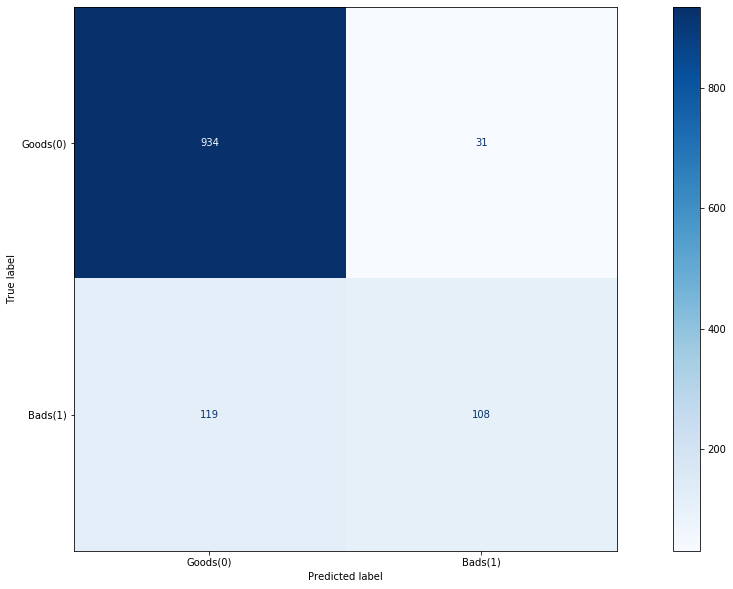

In [309]:
# 1. Quick and dirty way
cmat = metrics.confusion_matrix(y_test, sk_logit.predict(x_test))
print(cmat)
# 2. Pretty-print confusion matrix
metrics.plot_confusion_matrix(sk_logit, x_test, y_test, labels=[0, 1], display_labels=['Goods(0)', 'Bads(1)'], cmap='Blues',values_format='n')
plt.show()



What can we see on this table? Do you think, this is a good model? How do you calculate the accuracy from this table? Hint: remind yourself of how the variable BAD is distributed. 
Are both outcomes the same?

A great way to overcome some of these shortcomings is creating the ROC curve and calculating the AUC. For that we will need the True Positive Rate and False Positive Rate. Again, remind yourself that for this confusion matrix we would only consider one cut-off. To create a ROC curve this is done for all cut-offs.
The formulas as a quick reminder:
We are working with a boolean outcome variable in which 1 indicates 'BAD'. So the TPR and FPR will refer to 'BAD' as a positive. <br> <br>
TPR: 113/ (113+131) | True Positive / (all actual positives)

FPR: 36/(912+36)    | False Positive/ (actual no)

(info about confusion matrix here)

# ROC Curve and AUC

This is one of the most important evaluation metrics, specifically it is a ranking method. Have a look at the graph below. The curve tells us how well the model differntiates the two classes, in regards to their predicted probabilities.
A ROC curve has the FPR on the X-axis and FPR on the Y-axis.
The curve is made up out of all the different combinations of TPR and FPR at all threshold, creating a line.

The AUC stand for the Area under the Curvea and is a ranking indicator. The AUC estimates the probability that a randomly
chosen positive instance is correctly ranked higher than a randomly chosen negative (Hanley and McNeil, 1983) . We calculate this area, as our goal is to have a FPR of 0 and a TPR of 1. This would be the perfect model. This point is in the top right corner of a ROC Curve. So the closer we get to that point, the better the model and the bigger the area under it. . It is popular as it allows comparison of different kind of models.

So, we can plot the curve for both the training and test set evaluation.


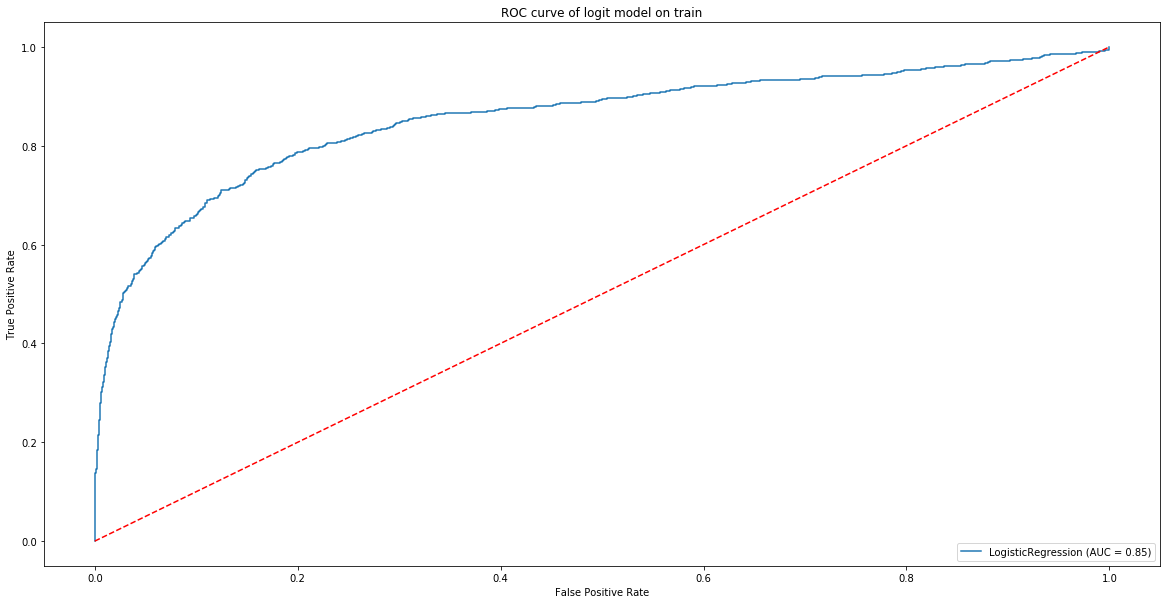

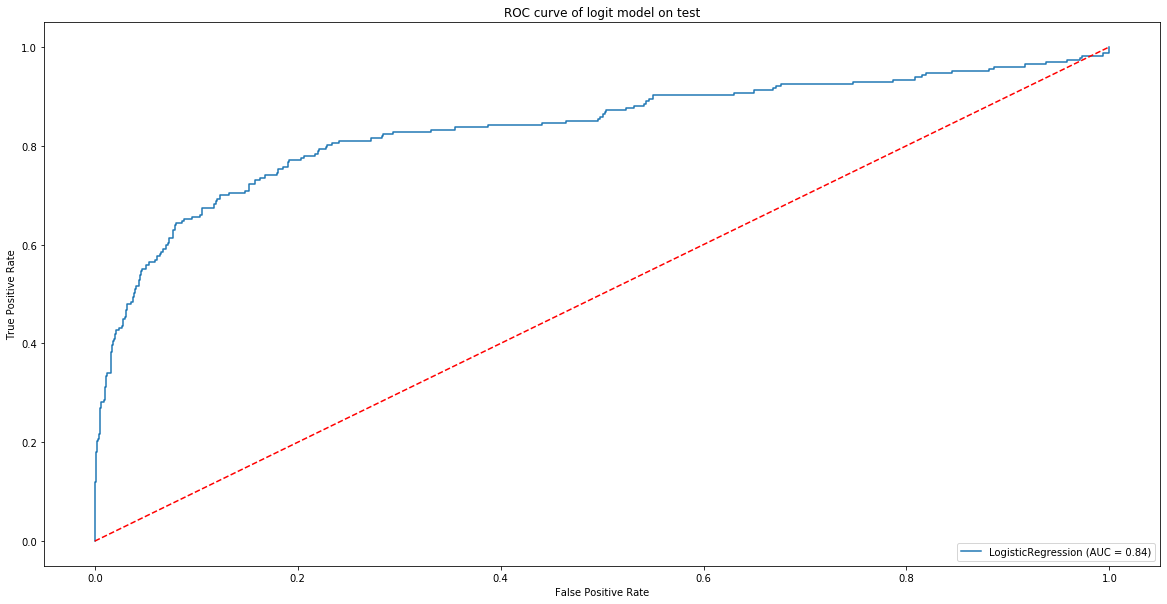

In [310]:
# simple way


metrics.plot_roc_curve(log, x_train, y_train)
plt.title('ROC curve of logit model on train')
plt.plot([0, 1], [0, 1], "r--")

metrics.plot_roc_curve(log, x_test, y_test);
plt.title('ROC curve of logit model on test')
plt.plot([0, 1], [0, 1], "r--")
plt.show()



Can you spot differences? Does a similar AUC indicate anything, considering we have evaluated both training and test set? Remember, evaluating using the training set is equivalent to the resubstitution estimate.

To make sure you understand how to extract the necessary metrics, we will compute the ROC Curve manually.

AUC on training data: 0.8362


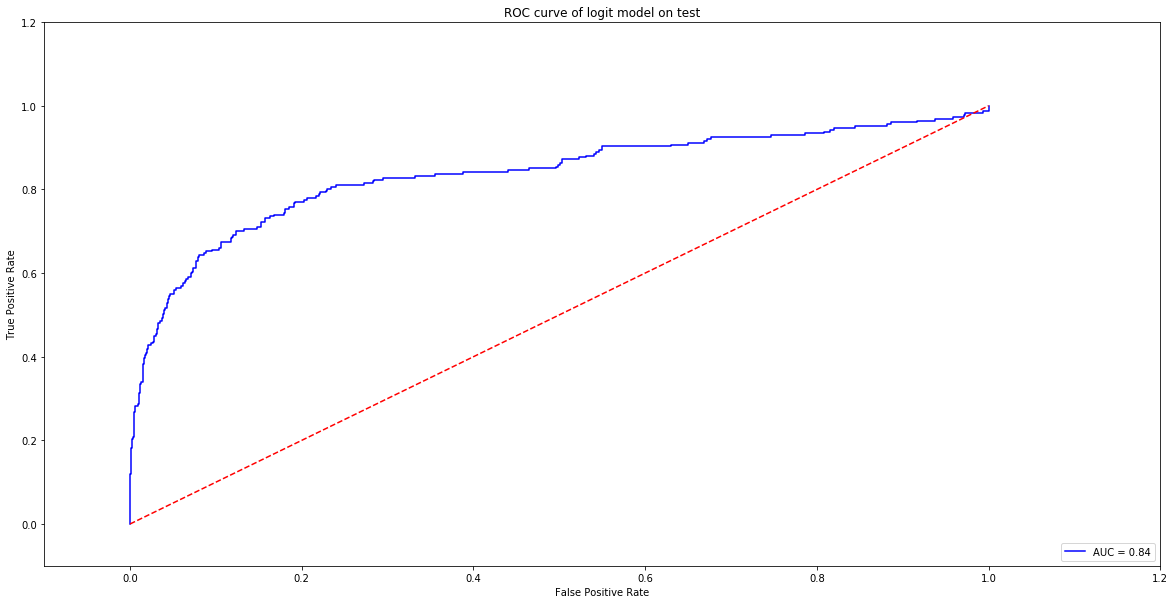

In [311]:
# Example how to 'manually' plot the ROC curve
yhat_logit = log.predict_proba(x_test)[:, 1]
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, yhat_logit) #extracting FPR and TPR
roc_auc = metrics.auc(fp_rate, tp_rate) #extract AUC value
print('AUC on training data: {:.4f}'.format(roc_auc))
plt.title('ROC curve of logit model on test')
plt.plot(fp_rate, tp_rate, "b", label="AUC = %0.2f" % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()


Let's make sure we save our results so we can later establish which is our best model.


In [312]:
fpr_results = []   # but find better way to save this later
fpr_results.append(fp_rate)
tpr_results = []
tpr_results.append(tp_rate)
auc_results =  []
auc_results.append(roc_auc)

In [313]:
fpr_results.append(fp_rate)
tpr_results[1:4] = []
tpr_results.append(tp_rate)
auc_results[1:4] = []
auc.append(roc_auc)

In [314]:
#try and compute average as well and plot that

# Cross-validation (model simulation)

Cross validation is an extendend approach of the split sample method. It consists of repeating the split sample method multiple times.

Step by step:
    -randomly split data in N disjoint folds (E.g., N=5) 
    -Build model on N-1 folds and validate that model on thw remaining fold 
- Apply trained model to predict cases in the validation sample (hold-out data) 
- measure model performance 
- Repeat N times and average 
- average model performance over validation folds gives performance estimate 
- Can also estimate standard deviation (e.g., for statistical hypothesis testing)

Cross-validating the logit model:
	CV iter: 0 with AUC=0.8436679790026247
Average AUC during cross-validation: 0.8437
	CV iter: 1 with AUC=0.8366961942257218
Average AUC during cross-validation: 0.8402
	CV iter: 2 with AUC=0.8540026246719159
Average AUC during cross-validation: 0.8448
	CV iter: 3 with AUC=0.8616305774278215
Average AUC during cross-validation: 0.8490
	CV iter: 4 with AUC=0.8559984689413823
Average AUC during cross-validation: 0.8504
	CV iter: 5 with AUC=0.817503280839895
Average AUC during cross-validation: 0.8449
	CV iter: 6 with AUC=0.8780249593054802
Average AUC during cross-validation: 0.8496
	CV iter: 7 with AUC=0.837683125339121
Average AUC during cross-validation: 0.8482
	CV iter: 8 with AUC=0.8550712719298245
Average AUC during cross-validation: 0.8489
	CV iter: 9 with AUC=0.8633223684210527
Average AUC during cross-validation: 0.8504


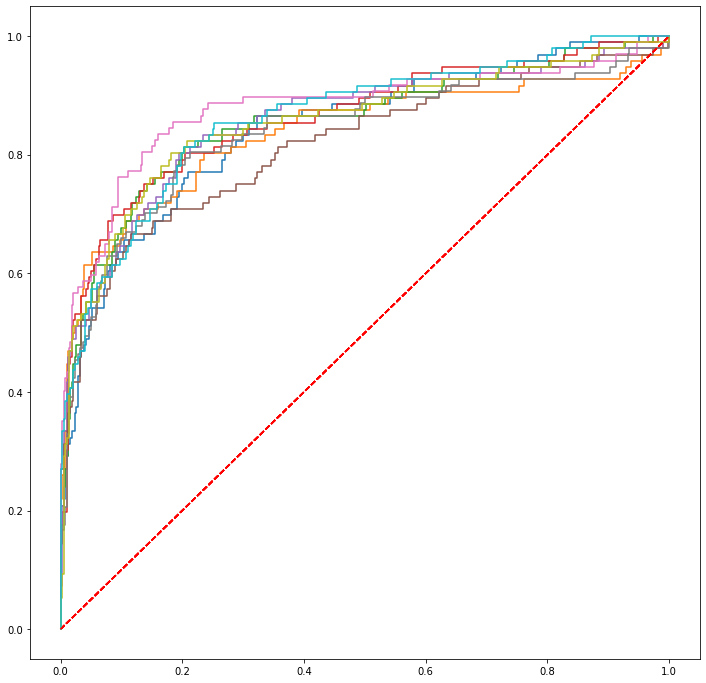

In [315]:
plt.figure(figsize=[12,12])
import matplotlib.pyplot as plt
resultscv = list()
tpr= list()
fpr=list()
nfold = 10
cv = StratifiedKFold(n_splits=nfold)
cv_auc = np.zeros(nfold)
cv_auc[cv_auc == 0] = 'nan' #for now, to avoid 0 values to be taken into account for average

print('Cross-validating the logit model:')
for i, (tr_idx, vl_idx) in enumerate(cv.split(x_train, y_train)):
    xtr, xvl = x_train.iloc[tr_idx], x_train.iloc[vl_idx]
    ytr, yvl = y_train.iloc[tr_idx], y_train.iloc[vl_idx]
    sk_logit.fit(xtr, ytr)
    a= sk_logit.predict_proba(xvl)[:, 1]
    resultscv.append(a.astype('float'))
    fp_rate, tp_rate, _ = metrics.roc_curve(yvl, a.astype('float'))
    cv_auc[i] = metrics.auc(fp_rate, tp_rate)
    print('\tCV iter: {} with AUC={}'.format(i, cv_auc[i]))
    print('Average AUC during cross-validation: {:.4f}'.format(np.nanmean(cv_auc, axis=0))) #how to avoid 0 to be
    fpr, tpr, thresholds = metrics.roc_curve(yvl ,a, pos_label=0)
    # Print ROC curve
    plt.plot(tpr,fpr)
    plt.plot([0, 1], [0, 1], "r--")
    
    
plt.show()
    
   

In [316]:
# Save results for comparison later! build average

In [317]:
auc_results.append(np.mean(cv_auc))

In [318]:
print(auc_results) #Change to data frame incl column names for better evaluation

[0.8362055191618544, 0.8503600850104839]


Looking at the curves of all models that have been developed, it should further deepen your understanding of the importance of model simulation and that different data leads to different results. You can always get a lucky sample. but make sure your model is robust.

# Regularizes Logit


(add text here about Lasso and penalties in general)

In [319]:
# Trying to improve performance using regularized logit
lasso = LogisticRegression(penalty='l1', C=0.1, fit_intercept=True, max_iter=200, solver='liblinear')
lasso.fit(x_train, y_train)
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, lasso.predict_proba(x_test)[:, 1])
print('Lasso test set AUC: {:.4f}'.format(metrics.auc(fp_rate, tp_rate)))

# Try finding a better setting for penalty parameter C
penalty_settings = {'C': [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 2, 3, 3, 4, 5, 10, 20]}
print('Grid-searching regularization parameter')
gs_lasso = GridSearchCV(lasso, penalty_settings, scoring='roc_auc', refit=True, cv=nfold)
gs_lasso.fit(x_train, y_train)
# Find test set auc of the best lasso model
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, gs_lasso.predict_proba(x_test)[:, 1])
print('Lasso test set AUC with best paramter: {:.4f}'.format(metrics.auc(fp_rate, tp_rate)))


Lasso test set AUC: 0.8291
Grid-searching regularization parameter
Lasso test set AUC with best paramter: 0.8362


In [320]:
auc_results.append(metrics.auc(fp_rate, tp_rate)) # save results

Both regularized regression show a slight improvement in our predictions. But can we do more?


## Random Forest

The random forest algorithm is an ensemble algorithm, with the goal to predicts the outcome variable by learning simple decision rules from the data features. In the random forest algorithm is based on several models built using bootstrap samples of the training set(random samples with replacement) and different random sample of attributes. This means instead of using all data in our training set and all attributes, we build many models on smaller subsets of the data AND the attributes. This allows the algorithms to pick up on more attributes, as the most important ones are not part of each random subspace. The base models are supposed to stay simple to avoid overfitting. 

Step by step:
- bootsrapping, create random subsets from training data
- at each node, only a random set of features is considered for the best split
- fit base model (usually decision tree)
- repeat until chosen amount of base models is reached
- average prediction of all trees and use this for evaluation

Metaparamters in our rid search:
n_estimators: number of trees in forest
criterion: splitting function to use
max_features : maximum features in random subspace
max_depth: pruning parameter, maximum depth of decision tree



Some more:
min_samples_split: minimum number of samples required in leaf node before another split is made. If it is less, this node wont split.
min_samples_leaf: minimum number of samples required to be at a leaf node.
max_leaf_nodes: maximum number of leaf nodes in a tree
n_jobs: parallelization of model building
random_state:
This parameter is used to define the random selection.
It is used for comparison between various models.

In [321]:
# Performance of tree-based ensemble algorithms in the form of random forest and gradient boosting
# 1. Random forest
print('Tuning random forest classifier')
rf = RandomForestClassifier(random_state=123)

# Define meta-parameter grid of candidate settings
# The following settings are just for illustration
param_grid = {'n_estimators': [500],
              'max_features': [1, 2, 4, 6],
              'max_depth': [5, 10, 20],
              'criterion' :['gini', 'entropy']
              }

# Set up the grid object specifying the tuning options
gs_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=1)
gs_rf.fit(x_train, y_train)
print("Best CV AUC: %0.4f" % gs_rf.best_score_)
print("Optimal RF meta-parameters:")
print(gs_rf.best_params_)
# Find test set auc of the best random forest classifier
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, gs_rf.predict_proba(x_test)[:, 1])
print('RF test set AUC: {:.4f}'.format(metrics.auc(fp_rate, tp_rate)))


Tuning random forest classifier
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 17.1min finished


Best CV AUC: 0.9733
Optimal RF meta-parameters:
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 1, 'n_estimators': 500}
RF test set AUC: 0.9816


In [322]:
#save results
auc_results.append(gs_rf.best_score_)
auc_results.append(metrics.auc(fp_rate, tp_rate))

What an improvement to our AUC. Both the cross validation as well as the AUC of the best parameters found in my grid search show great improvements. Evaluate the optimal meta-parameters. What conclusions can you draw? Make sure you understand the meaning of your metaparameters.


# Grid Search and Metaparameter Tuning

(add more info here)


# XGBoost

(add more info here)
Link: https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d #ok?

In [ ]:
# 2. Gradient boosting
# todo add some comments on scikit-learn implementation versus xgboost module

# XGBoost module recommends storing data in a different manner
# DM_train = xgb.DMatrix(data=x_train, label=y_train)
# DM_test = xgb.DMatrix(data=x_test, label=y_test)
# Setting up the grid of xgb hyperparameters
xgb_param_grid = {
    'colsample_bytree': np.linspace(0.5, 0.9, 5),
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.1, 0.01],
    'early_stopping_rounds': [10]
}
gs_xgb = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=xgb_param_grid, scoring='roc_auc', cv=5, verbose=1)
gs_xgb.fit(x_train, y_train)
print("Best CV AUC: %0.4f" % gs_xgb.best_score_)
print("Optimal XGB meta-parameters:")
print(gs_xgb.best_params_)
# Find test set auc of the best random forest classifier
fp_rate, tp_rate, _ = metrics.roc_curve(y_test, gs_xgb.predict_proba(x_test)[:, 1])
print('XGB test set AUC: {:.4f}'.format(metrics.auc(fp_rate, tp_rate)))


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
auc_results.append( gs_xgb.best_score_)
auc_results.append(metrics.auc(fp_rate, tp_rate))

## Feature Importance

(add info here)

In [ ]:
rcParams['figure.figsize'] = 20, 10

# Permutation-based variable importance
print('Computing permutation-based feature importance...')
from sklearn.inspection import permutation_importance

classifier = gs_rf.best_estimator_
perm_imp = permutation_importance(classifier, x_test, y_test, scoring='roc_auc', random_state=123)
sorted_idx = perm_imp.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
ax.set_title("Permutation importance (test set) of {}".format(str(classifier)[0:str(classifier).find('(')]))
fig.tight_layout()
plt.show()


In [ ]:
rcParams['figure.figsize'] = 20,40
# Partial dependence
from sklearn.inspection import plot_partial_dependence

print('Computing partial dependence plots...')
features = x_train.columns
plot_partial_dependence(classifier, x_train, features, n_jobs=3, grid_resolution=20)
# print("done in {:.3f}s".format(time() - tic))
fig = plt.gcf()
fig.suptitle('Partial dependence')
fig.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()


In [ ]:
#added, just for more info 

ranks = {}
from sklearn.preprocessing import MinMaxScaler
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

from sklearn.feature_selection import RFE
# Construct our Linear Regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train,y_train)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(x_train,y_train)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), x_train.columns, order=-1);

In [ ]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Ranking', ascending=False)

In [ ]:
colnames =x_train.columns
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

In [ ]:
import seaborn as sns 
ranktemp = pd.DataFrame(list(r.items()), columns= ['Feature','Ranking'])

# Sort the dataframe
ranktemp = ranktemp.sort_values('Ranking', ascending=False)
# Let's plot the ranking of the features
sns.catplot(x="Ranking", y="Feature", data = meanplot, kind="bar", 
            height=14, aspect=1.9, palette='coolwarm');


Things to do:  Save data appropriately for evaluation
               Algorithm evaluation
               Proof read
               Add text where mentioned
               Mean CV Roc Curve Plot
               Format markdown text consistently